In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import dotenv
os.chdir(dotenv.find_dotenv().replace('.env', ''))
from pseudobatch import pseudobatch_transform, pseudobatch_transform_multiple

## Testing with inhibited data set

In [2]:
dat = pd.read_csv(os.path.join("simulated_data", "product_inhibition.csv"))
dat.columns

Index(['Kc_s', 'mu_max', 'Yxs', 'Yxp', 'Yxco2', 'F0', 'mu0', 's_f', 'Ki_p',
       'sample_volume', 'p', 'timestamp', 'm_Glucose', 'm_Biomass',
       'm_Product', 'm_CO2', 'v_Volume', 'v_Feed_accum', 'c_Glucose',
       'c_Biomass', 'c_Product', 'c_CO2', 'c_Volume', 'c_Feed', 'mu_true'],
      dtype='object')

In [3]:
# Useful variables
concentration_columns = ['c_Biomass', 'c_Glucose', 'c_Product']

biomass_yields = {
    'Biomass': 1,
    'Glucose': -1.85,
    'Product': 0.822,

}

concentration_in_feed_dict = {
    'Biomass': 0,
    'Glucose' :100, 
    'Product':0
}

First, we need to calculate the true values for the cultivation parameters, $q_c$, and $r_c$ the volumetric and specific rates.

$$
q_c = X(t) * \mu(t) * Y_{xc} \\
r_c = \mu(t) * Y_{xc}
$$

In [4]:
def volumetric_rate(mu, yield_coef, biomass_conc):
    return mu * yield_coef * biomass_conc

def specific_rate(mu, yield_coef):
    return mu * yield_coef

In [5]:
## Calculate the true rates 
for colname in concentration_columns:
    _ , species = colname.split('_')
    dat[f'{species}_volumetric_rate_true'] = volumetric_rate(
        dat['mu_true'], 
        biomass_yields[species], 
        dat['c_Biomass']
    )

    dat[f'specific_{species}_rate_true'] = specific_rate(
        dat['mu_true'], 
        biomass_yields[species]
    )



The data contains two values for the sampling time points one is the before sample and on is the after sample.

In [6]:
meas = (dat
    .query("not(sample_volume.isna())")
    .filter([
        'p', 
        'timestamp', 
        'sample_volume', 
        'v_Volume', 
        'v_Feed_accum', 
        'mu_true', 
        'Glucose_volumetric_rate_true', 
        'Product_volumetric_rate_true', 
        'Biomass_volumetric_rate_true',
        'specific_Glucose_rate_true', 
        'specific_Product_rate_true', 
        'specific_Biomass_rate_true', 
        'c_Biomass', 
        'c_Glucose', 
        'c_Product'
    ])
    .copy()
)
meas['type'] = ["After sampling" if x else "Before sampling" for x in meas.timestamp.duplicated()]
meas = meas.query("type == 'Before sampling'") # for simplicity we remove the after sample time points
meas.head()

,p,timestamp,sample_volume,v_Volume,v_Feed_accum,mu_true,Glucose_volumetric_rate_true,Product_volumetric_rate_true,Biomass_volumetric_rate_true,specific_Glucose_rate_true,specific_Product_rate_true,specific_Biomass_rate_true,c_Biomass,c_Glucose,c_Product,type
167,"[0.15, 0.3, 1.85, 0.8215102466751038, 0.045193...",10.000000,100.0,1015.906036,15.906036,0.098350,-0.239268,0.106313,0.129334,-0.181947,0.080843,0.098350,1.315046,0.117208,0.676000,Before sampling
245,"[0.15, 0.3, 1.85, 0.8215102466751038, 0.045193...",14.545455,100.0,928.960902,28.960902,0.097930,-0.367071,0.163098,0.198416,-0.181170,0.080498,0.097930,2.026109,0.171224,1.265827,Before sampling
322,"[0.15, 0.3, 1.85, 0.8215102466751038, 0.045193...",19.090909,100.0,847.314262,47.314262,0.096131,-0.548379,0.243658,0.296421,-0.177842,0.079019,0.096131,3.083525,0.296168,2.143140,Before sampling
400,"[0.15, 0.3, 1.85, 0.8215102466751038, 0.045193...",23.636364,100.0,772.816654,72.816654,0.090714,-0.766665,0.340648,0.414414,-0.167821,0.074567,0.090714,4.568350,0.651151,3.375809,Before sampling
478,"[0.15, 0.3, 1.85, 0.8215102466751038, 0.045193...",28.181818,100.0,707.795685,107.795685,0.079949,-0.948139,0.421281,0.512507,-0.147906,0.065718,0.079949,6.410392,1.735493,4.907704,Before sampling


In [7]:
def mass_before_sample(conc:pd.Series, volume_before:pd.Series)->pd.Series: 
    return conc * volume_before

def mass_after_sample(conc:pd.Series, volume_before:pd.Series, sample_volume:pd.Series)->pd.Series:
    return conc * (volume_before - sample_volume)

In [8]:

for colname in concentration_columns:
    _, species = colname.split('_')
    meas[f'm_{species}_before'] = mass_before_sample(meas[colname], volume_before = meas.v_Volume)
    meas[f'm_{species}_after'] = mass_after_sample(meas[colname], volume_before = meas.v_Volume, sample_volume = meas.sample_volume)
meas

concentration_in_feed = np.array([0, 100, 0]).reshape(1,-1)

meas[['c_Biomass_pseudo', 'c_Glucose_pseudo', 'c_Product_pseudo']] = pseudobatch_transform_multiple(
    meas[concentration_columns].to_numpy(),
    meas.v_Volume.to_numpy(),
    meas.v_Feed_accum.to_numpy(),
    concentration_in_feed,
    meas.sample_volume.to_numpy()
)


In [9]:
def add_noise(x, relerr):
    return np.random.normal(x, x * relerr)

In [10]:
from functools import partial
np.random.seed(9854543) # 9042985
add_noise_closure = partial(add_noise, relerr = 0.05)
meas_noisy = meas.drop(columns=concentration_columns)

for colname in concentration_columns:
    _, species = colname.split('_')
    meas_noisy[colname] = meas[colname].apply(add_noise_closure)
    meas_noisy[colname + '_2'] = meas[colname].apply(add_noise_closure)
    meas_noisy[colname + '_3'] = meas[colname].apply(add_noise_closure)
    meas_noisy[f'm_{species}_before'] = mass_before_sample(meas_noisy[colname], volume_before = meas_noisy.v_Volume)
    meas_noisy[f'm_{species}_after'] = mass_after_sample(meas_noisy[colname], volume_before = meas_noisy.v_Volume, sample_volume = meas_noisy.sample_volume)
meas_noisy


concentration_in_feed = np.array([0, 100, 0, 0, 0]).reshape(1,-1)

meas_noisy[['c_Biomass_pseudo', 'c_Glucose_pseudo', 'c_Product_pseudo'] + ['c_Biomass_pseudo_2', 'c_Biomass_pseudo_3']] = pseudobatch_transform_multiple(
    meas_noisy[concentration_columns + ['c_Biomass_2', 'c_Biomass_3']].to_numpy(),
    meas_noisy.v_Volume.to_numpy(),
    meas_noisy.v_Feed_accum.to_numpy(),
    concentration_in_feed,
    meas_noisy.sample_volume.to_numpy()
)


## Gaussian process derivatives tool

In [11]:
import gaussianprocessderivatives as gp

x = np.array([meas_noisy.timestamp]).reshape(-1,1).ravel()
y = meas_noisy['c_Biomass_pseudo'].transform(np.log).to_numpy().reshape(-1,1).ravel()
errs = np.repeat(0.05**2, len(y))
g= gp.maternGP({0: (-10, 4), 1: (-4, 4), 2: (-4, 6)}, x, y, merrors=errs)
g.info()

hparam[0] determines the amplitude of variation
hparam[1] determines the stiffness
hparam[2] determines the variance of the measurement error


In [40]:
xpred = np.linspace(x.min(), x.max(), 100)
g.findhyperparameters()
g.results()
g.predict(xpred, derivs= 1, merrorsnew = np.repeat(0.05**2, len(xpred)))

log(max likelihood)= 4.856405e+00
hparam[0]= 6.194666e+00 [1.000000e-10, 1.000000e+04]
hparam[1]= 3.607962e+01 [1.000000e-04, 1.000000e+04]
hparam[2]= 1.180289e-04 [1.000000e-04, 1.000000e+06]


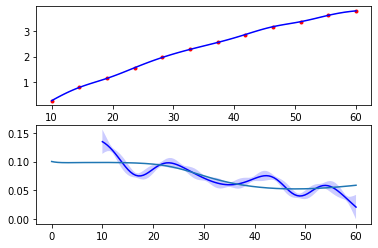

In [41]:
import matplotlib.pylab as plt
plt.figure()
plt.subplot(2,1,1)
g.sketch('.')
plt.subplot(2,1,2)
g.sketch('.', derivs= 1)
plt.plot(dat.timestamp, dat.mu_true)
plt.show()

In [42]:
f_pred, df_pred = g.sample(50, derivs= 1)

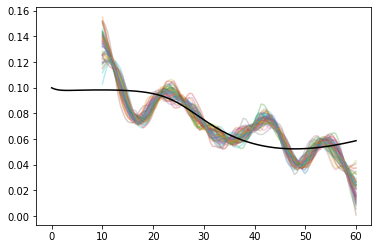

In [43]:
growth_rate = df_pred
for i in range(50):
    plt.plot(xpred, growth_rate[:,i], alpha = 0.3)
plt.plot(dat.timestamp, dat.mu_true, 'black')


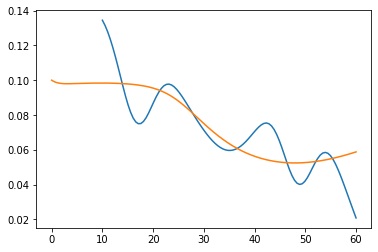

In [44]:
growth_rate = g.df
plt.plot(xpred, growth_rate)
plt.plot(dat.timestamp, dat.mu_true)

We see that the gaussian process overfits the data. Maybe there are too few measurements for this simple gaussian process model.

## With PyMC

In [45]:
import pymc3 as pm
import arviz as az
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v3.11.5


In [46]:

SEED = 90853624
x_obs= meas_noisy.timestamp.values.reshape(-1, 1)
y_obs = meas_noisy.c_Biomass_pseudo.values

with pm.Model() as model_hm:
    l = pm.HalfCauchy("l",10)
    η = pm.HalfCauchy("η", 10)
    sig = pm.HalfNormal("sig", 10)

    M = pm.gp.mean.Constant(c=0)
    cov = η * pm.gp.cov.ExpQuad(input_dim=1, ls=l) 

    gp_hm = pm.gp.Marginal(mean_func=M, cov_func=cov)
    ml_hm = gp_hm.marginal_likelihood("ml_hm", X=x_obs, y=y_obs, noise=sig)

    trace_hm = pm.sample(1000, tune=1000, return_inferencedata=True, random_seed=SEED)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, η, l]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


In [52]:
x_pred = np.linspace(x_obs.min(), x_obs.max(), 10000).reshape(-1, 1)

with model_hm:
    f_pred = gp_hm.conditional("f_pred", x_pred)

    pred_samples = pm.sample_posterior_predictive(trace_hm, var_names=["f_pred"], samples=100, random_seed=SEED)

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10000, 1) and (1000,)

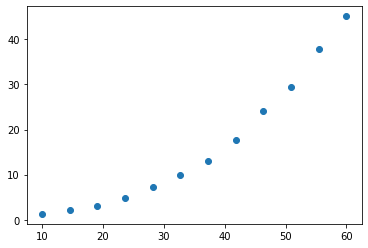

In [53]:
ax = plt.scatter(x_obs, y_obs, label='observed')
for pred in pred_samples['f_pred'][:100]:
    plt.plot(x_pred, pred, 'C0', alpha=0.5)


(-0.2, 0.2)

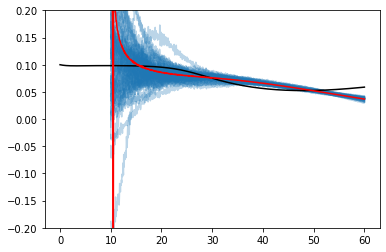

In [51]:
## Calculate numerical derivative
pred_samples['f_pred_derivative'] = np.gradient(pred_samples['f_pred'], x_pred.ravel(), axis=1)
pred_samples['growth_rate'] = pred_samples['f_pred_derivative'] / pred_samples['f_pred']

for pred in pred_samples['growth_rate'][:50]:
    plt.plot(x_pred, pred, 'C0', alpha=0.3)
plt.plot(dat['timestamp'], dat['mu_true'], color='black', label='true')
plt.plot(x_pred, pred_samples['growth_rate'].mean(axis=0), color='red', label='mean')
#plt.plot(x_pred, pred_samples['growth_rate'].percentiles(0.025, axis=0), color='red', label='mean')
plt.ylim(-0.2, 0.2)

(26.5, 30.0)

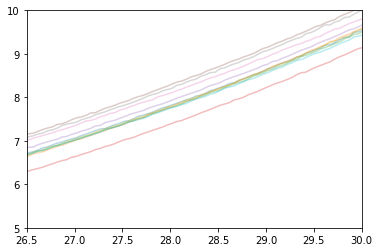

In [153]:
for pred in pred_samples['f_pred'][:10]:
    plt.plot(x_pred, np.exp(pred), alpha=0.3)
plt.ylim(5, 10)
plt.xlim(26.5, 30)

In [40]:
pred_samples['growth_rate'].std(axis=0)
pred_samples['f_pred_derivative'].mean(axis=0)[600:620]


array([0.01507114, 0.01467838, 0.01422518, 0.01390739, 0.01353209,
       0.01311009, 0.01278046, 0.01240077, 0.01204787, 0.01158816,
       0.01125018, 0.0109494 , 0.01051648, 0.01020633, 0.00979192,
       0.0094824 , 0.0091522 , 0.00875658, 0.00840015, 0.00807806])

array([<AxesSubplot:title={'center':'l'}>,
       <AxesSubplot:title={'center':'η'}>,
       <AxesSubplot:title={'center':'sig'}>], dtype=object)

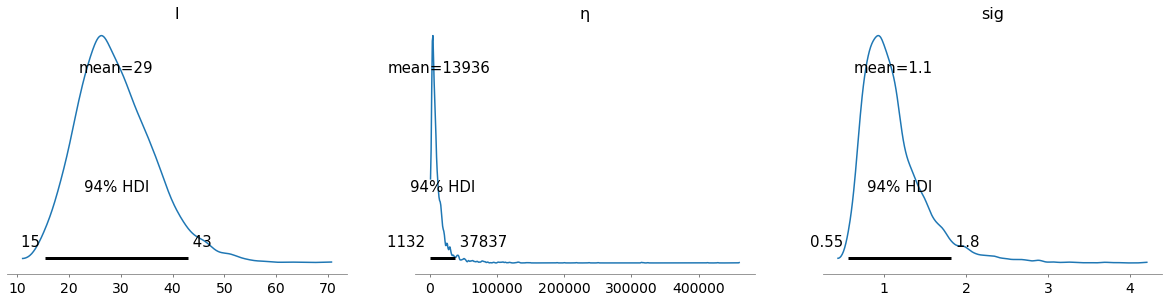

In [74]:
az.plot_posterior(trace_hm)

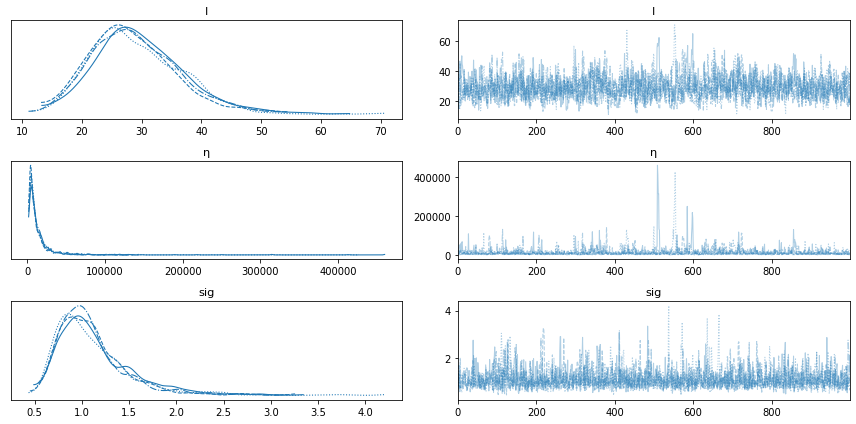

In [75]:
az.plot_trace(trace_hm)
plt.tight_layout()

## Adding derivative process
Now I will add a second gaussian process which model the derivative of the first. Thus, we need to know the covariance between the biomass and the growth rate (the derivative). 

### Testing Stan


In [110]:
from cmdstanpy import CmdStanModel
stan_model = CmdStanModel(stan_file='src/stan/simple_gp.stan')

/Users/s143838/.virtualenvs/fedbatch-data-correction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
16:44:37 - cmdstanpy - INFO - compiling stan file /Users/s143838/projects/fedbatch-data-correction/src/stan/simple_gp.stan to exe file /Users/s143838/projects/fedbatch-data-correction/src/stan/simple_gp
16:44:56 - cmdstanpy - INFO - compiled model executable: /Users/s143838/projects/fedbatch-data-correction/src/stan/simple_gp
16:44:56 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
16:44:56 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/s143838/projects/fedbatch-data-correction/src/stan/simple_gp.hpp /Users/s143838/projects/fedbatch-data-correction/src/stan/simple_gp.stan
Warning in '/Users/s143838/projects/fedbatch-data-correction/src/stan/simple

In [115]:
T = len(x_pred) # number of grip points
x_pred # x values for prediction
pred_derivatives = n

array([[10.        ],
       [10.05005005],
       [10.1001001 ],
       [10.15015015],
       [10.2002002 ],
       [10.25025025],
       [10.3003003 ],
       [10.35035035],
       [10.4004004 ],
       [10.45045045],
       [10.5005005 ],
       [10.55055055],
       [10.6006006 ],
       [10.65065065],
       [10.7007007 ],
       [10.75075075],
       [10.8008008 ],
       [10.85085085],
       [10.9009009 ],
       [10.95095095],
       [11.001001  ],
       [11.05105105],
       [11.1011011 ],
       [11.15115115],
       [11.2012012 ],
       [11.25125125],
       [11.3013013 ],
       [11.35135135],
       [11.4014014 ],
       [11.45145145],
       [11.5015015 ],
       [11.55155155],
       [11.6016016 ],
       [11.65165165],
       [11.7017017 ],
       [11.75175175],
       [11.8018018 ],
       [11.85185185],
       [11.9019019 ],
       [11.95195195],
       [12.002002  ],
       [12.05205205],
       [12.1021021 ],
       [12.15215215],
       [12.2022022 ],
       [12

In [111]:
import json

gp_data = {
 "N" : N,
 "x" : [0,1,0,0,0,0,0,0,0,1]
}
json.dump(simple_gp_data, open('src/stan/simple_gp_data.json', 'w'))

In [112]:
s = stan_model.sample(data='src/stan/simple_gp_data.json', seed=12345, chains=2)

16:46:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                     


16:46:17 - cmdstanpy - INFO - CmdStan done processing.


In [113]:
netcdf = az.from_cmdstanpy(
    posterior=s,
    
)

In [114]:
netcdf

Inference data with groups:
	> posterior
	> sample_stats

## Fitting B-splines

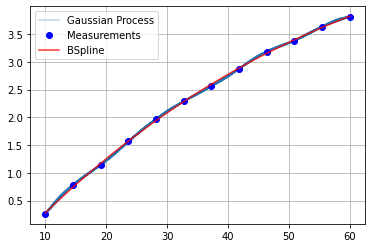

In [27]:
from scipy import interpolate

x = meas_noisy.timestamp
y = meas_noisy.c_Biomass_pseudo.transform(np.log)
weights = np.repeat(1/0.05, len(y))
t, c, k = interpolate.splrep(x, y, w=weights, k=3)
spline = interpolate.BSpline(t, c, k, extrapolate=False)

for i in range(50):
    plt.plot(xpred, f_pred[:,i], color='C0', alpha = 0.3, label='Gaussian Process')
plt.plot(x, y, 'bo', label='Measurements')
plt.plot(xpred, spline(xpred), 'r', label='BSpline', alpha = 0.8)
plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

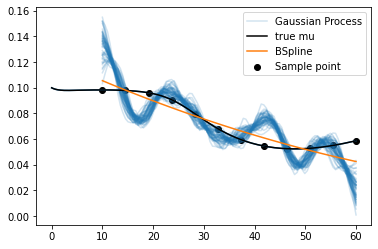

In [48]:

plt.plot(dat.timestamp, dat.mu_true)  
growth_rate = df_pred
for i in range(50):
    plt.plot(xpred, growth_rate[:,i], color='C0', alpha = 0.2, label='Gaussian Process')
plt.plot(dat.timestamp, dat.mu_true, 'black', label='true mu')  
plt.plot(xpred, spline.derivative()(xpred), label='BSpline')
plt.scatter(meas.timestamp, meas.mu_true, color='black', label='Sample point')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


In [19]:
spline = interpolate.make_smoothing_spline(x, y) 

plt.plot(x, y, 'bo', label='Original points')
plt.plot(xpred, spline(xpred), 'r', label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.show()

AttributeError: module 'scipy.interpolate' has no attribute 'make_smoothing_spline'

AttributeError: 'numpy.ndarray' object has no attribute 'plot'